In [1]:
%run "..\src\utils\notebook_style.ipynb"

# Numerische Integration der Krümmung

## Einführung

Ziel ist die Deformationen des Versuchs A3 in der Versuchsanordnung 2 aus @Jaeger2006 nachzurechnen.

## Momenten-Krümmungsdiagramm

Das Momenten-Krümmungsdiagramm ist geeignet zur Beschreibung des Tragverhaltens von überwiegend auf Biegung beanspruchte Stabtragwerke.
Zur rechnerischen Ermittlung gelten folgende Annahmen, wie in @Spathelf2022 beschrieben:

- Eben- und senkrechtbleiben der Querschnitte
- Die Betonzugfestigkeit $f_{ct}$ wird, für Zustände nach dem Überschreiten von $f_{ct}$, vernachlässigt
- Linear elastisches Verhalten von Stahl und Beton für die Spannungs- und Verformungsberechnung
- Die Bewehrung überträgt Zug- und Druckkräfte ausschliesslich in Stabrichtung

### Anwendung auf Versuchsbeispiel

Folgend wird ein Momentenkrümmungsdiagramm für den Querschnitt aus dem beschriebenen Versuch berechnet. Die vorhandene Querkraftbewehrung ist nicht dargestellt in @fig-qs_a3.


![Querschnitt des Versuchs A3 zur Bestimmung des Momenten-Krümmungdiagramms](../images/QS_Versuch_A3.svg){#fig-qs_a3}



#### Verwendete Parameter

In [2]:
f_ct, E_c, b, h, W_c, M_r, E_s= sp.symbols('f_ct, E_c, b, h, W_c, M_r E_s')

A_i, A_c, A_s, s_x, diam_s = sp.symbols('A_i, A_c, A_s, s_x \\oslash_s')

chi_r, I_1 = sp.symbols('chi_r, I^I')

zeta_c, c_nom, I_2 = sp.symbols('zeta_c c_nom I^{II}')

chi = sp.Function('chi')(M)

Eq_list = []

In [3]:
params = {
    f_ct:3.*unit.N / unit.mm**2,
    E_c:37700.*unit.N / unit.mm**2,
    E_s:200000.*unit.N / unit.mm**2,
    b:800.*unit.mm,
    h:200.*unit.mm,
    s_x: 80.*unit.mm,
    diam_s:12.*unit.mm,
    c_nom:20.*unit.mm,
    F:210000*unit.N,

}

params_plot = convert.param_value(params)
render.dict_to_table(params)

|   |   |
|---|---|
| $E_{c} = \frac{37700.0 \text{N}}{\text{mm}^{2}}$ | $E_{s} = \frac{200000.0 \text{N}}{\text{mm}^{2}}$ |
| $F = 210000 \text{N}$ | $\oslash_{s} = 12.0 \text{mm}$ |
| $b = 800.0 \text{mm}$ | $c_{nom} = 20.0 \text{mm}$ |
| $f_{ct} = \frac{3.0 \text{N}}{\text{mm}^{2}}$ | $h = 200.0 \text{mm}$ |
| $s_{x} = 80.0 \text{mm}$ | |


#### Schwerpunkt des Querschnitts

Durch die Bestimmung der Wertigkeit $n$ kann der Querschnitt als homogener Betonquerschnitt zur Bestimmung des Schwerpunkts behandelt werden.

In [4]:
eq_n = sp.Eq(n, E_s / E_c)
eq_n_num = eq_n.subs(params)
Eq_list.append(eq_n)
display(eq_n,eq_n_num.evalf(3))

     Eₛ
n = ───
    E_c

n = 5.3

Die Querschnittsfläche der Bewehrung:

In [5]:
eq_A_s = sp.Eq(A_s, sp.Mul(2*unit.m,sp.pi * diam_s **2 / (4 * s_x), evaluate=False))
eq_A_s_num = unit.convert_to(eq_A_s.subs(params).evalf(4).simplify(), unit.mm)

Eq_list.append(eq_A_s)
display(eq_A_s, eq_A_s_num)

                       2
             π⋅\oslashₛ 
Aₛ = 2⋅meter⋅───────────
                 4⋅sₓ   

                      2
Aₛ = 2827.0⋅millimeter 

Die Betonquerschnittsfläche:

In [6]:
eq_A_c = sp.Eq(A_c, b*h)
eq_A_c_num = unit.convert_to(eq_A_c.subs(params).simplify(), unit.mm)
Eq_list.append(eq_A_c)

display(eq_A_c, eq_A_c_num)

A_c = b⋅h

                         2
A_c = 160000.0⋅millimeter 

Die ideelle Querschnittsfläche resultiert zu:

In [7]:
eq_Ai = sp.Eq(A_i, A_c + A_s *(n-1))
eq_Ai_num = unit.convert_to(Eq_subs(eq_Ai, eq_A_s, eq_n, eq_A_c).subs(params)
, unit.mm)

Eq_list.append(eq_Ai)

display(eq_Ai,eq_Ai_num.evalf(6))

Aᵢ = A_c + Aₛ⋅(n - 1)

                        2
Aᵢ = 172172.0⋅millimeter 

In [8]:
eq_zeta_c = sp.Eq(zeta_c, sp.Mul(1/A_i,A_c * h/2 + A_s*(n-1) * (c_nom +1.5*diam_s), evaluate=False))
eq_zeta_c_num = unit.convert_to(Eq_subs(eq_zeta_c,eq_A_c, eq_A_s, eq_Ai, eq_n, eq_A_c, eq_A_s).subs(params), unit.mm)

Eq_list.append(eq_zeta_c)

display(eq_zeta_c, eq_zeta_c_num.simplify().evalf(3))

      A_c⋅h                                   
      ───── + Aₛ⋅(1.5⋅\oslashₛ + cₙₒₘ)⋅(n - 1)
        2                                     
ζ_c = ────────────────────────────────────────
                         Aᵢ                   

ζ_c = 95.6⋅millimeter

#### Flächenträgheitsmoment

Das Flächenträgheitsmoment wird ebenfalls am ideellen Querschnitt bestimmt. Die Eigenträgheitsmomente der Kreisquerschnitte der Bewehrung sind nicht berücksichtigt, lediglich der Steiner-Anteil fliesst in die Berechnung ein:

In [9]:
eq_I_1 = sp.Eq(I_1, b * h**3/12 +b*h*(h/2 - zeta_c)**2 + A_s * (n-1) * (c_nom + sp.Rational(1.5)*diam_s - zeta_c)**2)
eq_I_1_num = unit.convert_to(Eq_subs(eq_I_1,eq_A_s, eq_zeta_c, eq_n,eq_A_c, eq_A_s, eq_Ai,eq_A_c, eq_n, eq_A_s).subs(params).simplify(), unit.mm)

Eq_list.append(eq_I_1)

eq_EI_1 = sp.Eq(I_1 * E_c, eq_I_1.rhs * E_c)
eq_EI_1_num = sp.Eq(I_1*E_c,Eq_subs(eq_EI_1.rhs, *Eq_list).subs(params)).simplify()

Eq_list.append(eq_EI_1)
display(eq_I_1, eq_I_1_num.evalf(3), eq_EI_1, eq_EI_1_num.evalf(3))

                                           2      3                2
                  ⎛3⋅\oslashₛ             ⎞    b⋅h        ⎛h      ⎞ 
I__I = Aₛ⋅(n - 1)⋅⎜────────── + cₙₒₘ - ζ_c⎟  + ──── + b⋅h⋅⎜─ - ζ_c⎟ 
                  ⎝    2                  ⎠     12        ⎝2      ⎠ 

                         4
I__I = 5.77e+8⋅millimeter 

               ⎛                                    2      3                2⎞
               ⎜           ⎛3⋅\oslashₛ             ⎞    b⋅h        ⎛h      ⎞ ⎟
E_c⋅I__I = E_c⋅⎜Aₛ⋅(n - 1)⋅⎜────────── + cₙₒₘ - ζ_c⎟  + ──── + b⋅h⋅⎜─ - ζ_c⎟ ⎟
               ⎝           ⎝    2                  ⎠     12        ⎝2      ⎠ ⎠

                        2       
E_c⋅I__I = 2.17e+7⋅meter ⋅newton


#### Rissmoment

Durch die Ermittlung des Rissmoments kann die Krümmung vor dem Reissen des Betons ermittelt werden. Der Querschnitt wird als frei von Eigenspannungen betrachtet:


In [10]:
eq_W_c = sp.Eq(W_c,I_1 / (h/2))
eq_W_c_num = Eq_subs(eq_W_c, *Eq_list).subs(params).simplify()
Eq_list.append(eq_W_c)


eq_M_r = sp.Eq(M_r,f_ct * W_c)
eq_M_r_num = Eq_subs(eq_M_r, *Eq_list).subs(params).simplify()
Eq_list.append(eq_M_r)


eq_chi_r = sp.Eq(chi_r, M_r / (E_c * I_1))
eq_chi_r_num = Eq_subs(eq_chi_r, *Eq_list).subs(params).simplify()
Eq_list.append(eq_chi_r)

display(eq_W_c,eq_W_c_num.evalf(3), eq_M_r,eq_M_r_num.evalf(3), eq_chi_r,eq_chi_r_num.evalf(3))

      2⋅I__I
W_c = ──────
        h   

                   3
W_c = 0.00577⋅meter 

Mᵣ = W_c⋅f_ct

Mᵣ = 1.73e+4⋅meter⋅newton

        Mᵣ   
χᵣ = ────────
     E_c⋅I__I

      7.96e-7  
χᵣ = ──────────
     millimeter

#### Gerissen Elastisch

Nach dem Reissen des Betons bestimmt sich die Biegesteifigkeit aus der Dehnung des Betonstahls. Dabei wird eine allfällige Zugversteifung zwischen den Rissen vernachlässigt.

![Alt text](image.png)

Dabei beträgt die statische Höhe:

In [11]:
eq_d = sp.Eq(d,h - c_nom - sp.Rational(1.5) * diam_s)
eq_d_num = eq_d.subs(params)

Eq_list.append(eq_d)
display(eq_d, eq_d_num)

      3⋅\oslashₛ           
d = - ────────── - cₙₒₘ + h
          2                

d = 162.0⋅millimeter

Der Bewehrungsgehalt:

In [12]:
eq_rho = sp.Eq(rho,A_s / (b*d))
eq_rho_num = Eq_subs(eq_rho, eq_A_s_num, eq_d_num).subs(params)

Eq_list.append(eq_rho)

display(eq_rho, eq_rho_num.evalf(3))

     Aₛ
ρ = ───
    b⋅d

ρ = 0.0218

Die Druckzonenhöhe:

In [13]:
eq_x = sp.Eq(x,d*(sp.sqrt((rho*n)**2 + 2*rho*n) - rho*n))
eq_x_num = Eq_subs(eq_x,eq_rho_num, eq_n_num,eq_A_s_num, eq_d_num).subs(params)
Eq_list.append(eq_x)
display(eq_x, eq_x_num.evalf(3))

      ⎛          _______________⎞
      ⎜         ╱  2  2         ⎟
x = d⋅⎝-n⋅ρ + ╲╱  n ⋅ρ  + 2⋅n⋅ρ ⎠

x = 61.4⋅millimeter

Daraus lässt sich die gerissene Biegesteifigkeit ermitteln:

In [14]:
eq_I_2 = sp.Eq(I_2, A_s * (d-x)*(d-x/3))
eq_I_2_num = unit.convert_to(sp.Eq(I_2, Eq_subs(eq_I_2,*Eq_list).subs(params).simplify().rhs), unit.mm)


eq_EI_2 = sp.Eq(I_2 * E_s, eq_I_2.rhs * E_s)

eq_EI_2_num = sp.Eq(E_s*I_2, Eq_subs(eq_EI_2.rhs, eq_A_s, eq_d, eq_x, eq_n, eq_rho).subs(params).simplify())

Eq_list.extend([eq_I_2, eq_EI_2])



display(eq_I_2, eq_I_2_num.evalf(3), eq_EI_2, eq_EI_2_num.evalf(3))

                     ⎛    x⎞
I__{II} = Aₛ⋅(d - x)⋅⎜d - ─⎟
                     ⎝    3⎠

                            4
I__{II} = 4.03e+7⋅millimeter 

                           ⎛    x⎞
Eₛ⋅I__{II} = Aₛ⋅Eₛ⋅(d - x)⋅⎜d - ─⎟
                           ⎝    3⎠

                          2       
Eₛ⋅I__{II} = 8.05e+6⋅meter ⋅newton

#### Momenten-Krümmungsdiagramm

Abschliessend lässt sich daraus die Beziehung zwischen Moment und Krümmung darstellen:

In [15]:
eq_chi_M = sp.Eq(chi, sp.Piecewise((0,M<0),(M/ (E_c * I_1), M < eq_M_r.lhs), (M_r/(E_c*I_1 ) +M/(E_s*I_2), M>=eq_M_r.lhs)))

display(eq_chi_M)

       ⎧          0            for M < 0 
       ⎪                                 
       ⎪         M                       
       ⎪      ────────         for M < Mᵣ
χ(M) = ⎨      E_c⋅I__I                   
       ⎪                                 
       ⎪    M           Mᵣ               
       ⎪────────── + ────────  otherwise 
       ⎩Eₛ⋅I__{II}   E_c⋅I__I            

In [16]:
M_chi_params = [E_c,
                E_s,
                eq_I_1_num.rhs,
                eq_I_2_num.rhs,
                eq_M_r_num.rhs,
                ]

for param in enumerate(M_chi_params):
    M_chi_params[param[0]] = np.float64(unit.convert_to(param[1],[unit.m, unit.N]).subs([(unit.m,1),(unit.N,1)]).subs(params_plot))


![Momenten-Krümmungsdiagramm aus RFEM](image-3.png)

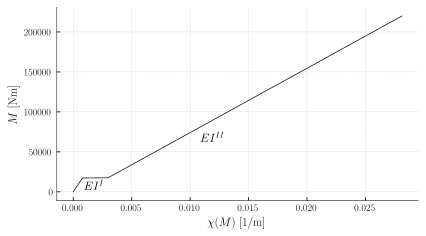

In [17]:
#| label: fig-mchi_diagramm
#| fig-cap: Momenten-Krümmungsdiagramm händisch ermittelt, definiert im positiven Bereich

chi_M_lambda = sp.lambdify((M, E_c, E_s, I_1, I_2, M_r), eq_chi_M.rhs)
M_array = np.linspace(0,220000,5000)
chi_M_array = chi_M_lambda(M_array, *M_chi_params)

plt.plot(chi_M_array, M_array, color='black')

# Anmerkungen hinzufügen


plt.annotate('$EI^I$', xy=(0.0009, 15000), xytext=(0, -10), textcoords='offset pixels')
plt.annotate("$EI^{II}$", xy=(0.01, 50000), xytext=(10, 10), textcoords='offset pixels')

plt.xlabel(f'${sp.latex(chi)}$ [1/m]')
plt.ylabel(f'${sp.latex(M)}$ [Nm]')
plt.show()


#### Zustandslinien der Biegemomente

Da die Beziehung zwischen Biegemoment und Krümmung bestimmt ist, kann ein Krümmungsverlauf über die Stabachse ermittelt werden. Dieser ist abhängig von der Funktion der Biegemomente zur Stabachse. 

![Aus RFEM6](image-1.png)

In [18]:
M_x = sp.Function('M')(x)

F_A = F * (1.67-0.11) / (1.67 - 0.75)

eq_M_x = sp.Eq(M_x, sp.Piecewise((0,x<=.110),(F * (x-0.11), .750>x), (F * 0.64-(F_A-F) * (x-0.75), x<=1.670), (0,x>1.670)))
M_x_lambda = sp.lambdify((x, F),eq_M_x.rhs)
x_array = np.linspace(0,2.620,5000)
M_x_array = M_x_lambda(x_array, F.subs(params_plot))

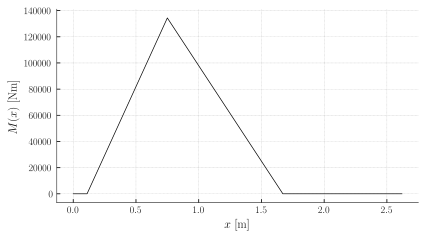

In [19]:
#| label: fig-m_y_diagramm
#| fig-cap: Biegemomentenverlauf für die Laststufe LS14


plt.plot(x_array, M_x_array, color='black')

plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'${sp.latex(M_x)}$ [Nm]')
plt.show()


#### Zustandslinien der Krümmung

Die Funktion der Biegemomente $M(x)$ als Eingabe in die Funktion der Krümmung $\chi(M)$ resultiert zu folgender Zustandslinie der Krümmung.


In [20]:
chi_M_versuch_2 = chi_M_lambda(M_x_array, *M_chi_params)


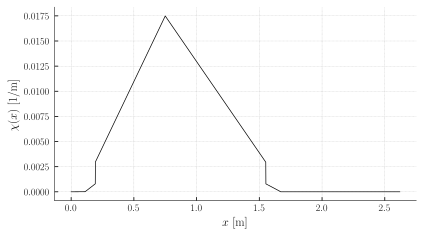

In [21]:
#| label: fig-chi_x_diagramm
#| fig-cap: Krümmungsverlauf für die Laststufe LS14 entlang der Stabachse

plt.plot(x_array, chi_M_versuch_2, color='black')

plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'$\chi(x)$ [1/m]')
plt.show()


#### Punktuelle Bestimmung der Deformation

Unter Anwendung der Arbeitsgleichung kann die Deformation nach @eq-arbeitsgleichung bestimmt werden.

$$
w = \int_0^l \bar{M}(x) \cdot \frac{M(x)}{EI} d_x
$${#eq-arbeitsgleichung}

Wobei $\frac{M(x)}{EI} = \chi(x)$ gilt.

Das heisst es gilt die Zustandslinien der Krümmung multipliziert mit der Zustandslinie der Biegemomente des virtuellen Kräftezustands über die Stablänge zu integrieren.

In [22]:
M_x_array_bar = M_x_lambda(x_array, 1)

![Aus RFEM6 für Einheitskraft](image-2.png)

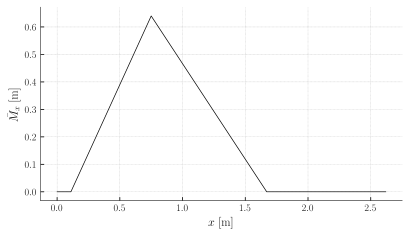

In [23]:
#| label: fig-m_y_diagramm_virtuell
#| fig-cap: Biegemomentenverlauf für den virtuellen Kräftezustand


plt.plot(x_array, M_x_array_bar, color='black')

plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel('$\\bar{M}_x$ [m]')
plt.show()

In [24]:
def arbeitsgleichung(x):
    return M_x_lambda_bar(x)*chi_M_lambda(M_x_lambda(x), *M_chi_params)

In [25]:
w_p1 = sp.symbols('w_p1')

Unter Anwedung der @eq-arbeitsgleichung folgt die Deformation bei der Krafteinleitung $F_A$ zu:

In [26]:
eq_w_p1 = unit.convert_to(sp.Eq(w_p1, integrate.quad(lambda x: M_x_lambda(x, 1)*chi_M_lambda(M_x_lambda(x, F.subs(params_plot)), *M_chi_params), 0, 2.620)[0]*unit.m), unit.mm)

eq_w_p1.evalf(3)

wₚ₁ = 5.94⋅millimeter